In [1]:
# imports and setup
%load_ext autoreload
%autoreload 2
%cd '/home/naodell/work/hgcal/analysis'

/home/naodell/work/hgcal/analysis


In [2]:
import os
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn import preprocessing
import seaborn as sns
from tqdm.notebook import tqdm, trange

from models.autoencoder import AutoEncoderModular, AutoEncoderModularConnected
from models.loss import mse_loss_regularized
from datasets.hgcal_tc_dataset import HGCalTCModuleDictDataset

#%connect_info

In [3]:
# get the data
input_dir = 'local_data/econ_training_data/single_photon_data/'
input_filenames = [f'{input_dir}/{f}' for f in os.listdir(input_dir)]
hgcal_data = HGCalTCModuleDictDataset(input_filenames)

# sample from dataframe according to event weights; split into testing and training sets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# training sample
batch_size = 16
n_total = len(hgcal_data)
split = round(0.8*n_total)
train_loader = DataLoader(hgcal_data[:split],  batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(hgcal_data[split:],  batch_size=batch_size, shuffle=True, pin_memory=True)
print(f'Total number of events: {n_total}')

Total number of events: 19114


In [4]:
# define and setup the NN model
scenario = 'modular_connected'
model = AutoEncoderModularConnected(encode_size=16).to(device)
print(device, model, sep='\n')

cuda
AutoEncoderModularConnected(
  (encoder): ModuleDict(
    (0): WaferEncoder(
      (conv2d): Conv2d(14, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=14, bias=False)
      (act_conv): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dense_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=128, out_features=16, bias=True)
          (1): ReLU()
        )
        (1): Sequential(
          (0): Linear(in_features=128, out_features=16, bias=True)
          (1): ReLU()
        )
        (2): Sequential(
          (0): Linear(in_features=128, out_features=16, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=16, bias=True)
          (1): ReLU()
        )
        (4): Sequential(
          (0): Linear(in_features=128, out_features=16, bias=True)
          (1): ReLU()
        )
        (5): Sequential(
          (0): Line

In [ ]:
# optimize NN weights
n_epochs = 50
n_events = len(train_loader)

# define loss and configure optimizer
loss_fn = nn.HuberLoss(reduction='sum')
#loss_fn = mse_loss_regularized

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
tb_writer = SummaryWriter(log_dir='logs')

pbar1 = tqdm(range(n_epochs), total=n_epochs, leave=False, position=0)
pbar1.set_postfix({'avg. loss':'?'})
loss_cache = []
for iepoch in pbar1:
    model.train()
    pbar2 = tqdm(train_loader, total=n_events, leave=False, position=1)
    pbar2.set_postfix({'loss':'?'})
    avg_loss = 0
    for jevent, (features, keys) in enumerate(pbar2):
        #features = features.unsqueeze(1).to(device)
        features = features.to(device)
        #targets = targets.to(device)
        optimizer.zero_grad()
        features_pred = model(features, keys)
        loss = loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
        loss.backward()
        optimizer.step()
        
        #pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
        #tb_writer.add_scalar('training loss', loss.item(), iepoch*n_events + jevent)
        
        avg_loss += loss.item()
        if jevent%10 == 0:
            avg_loss /= 10
            pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
            tb_writer.add_scalar('training loss', loss.item(), iepoch*(n_events//10) + jevent/10)
            avg_loss = 0
        
    with torch.no_grad():
        model.eval()
        test_loss = 0
        n_test_events = len(test_loader)
        for features, keys in tqdm(test_loader, total=n_test_events, leave=False):
            features = features.to(device)
            #targets = targets.to(device)
            features_pred = model(features, keys)
            #tqdm.write(features_pred.shape, features.shape)
            test_loss += loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
            loss_cache.append(test_loss.item())
            
            
        avg_loss = test_loss.item()/n_test_events
        pbar1.set_postfix({'avg loss':f'{avg_loss:.3f}'})
        tb_writer.add_scalar('test loss', avg_loss, iepoch)
        #tb_writer.add_graph(model, features)
        
        #images = torchvision.utils.make_grid(features)
        #images_pred = torchvision.utils.make_grid(features_pred)
        #tb_writer.add_image('input', images)
        #tb_writer.add_image('output', images_pred)
        
        # write a checkpoint based on the performance of the model



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

In [9]:
# compare images
import utils.plot_tools as pt
from matplotlib.colors import LogNorm

output_dir = Path(f'plots/{scenario}')
output_dir.mkdir(parents=True, exist_ok=True)
with torch.no_grad():
    model.eval()
    
    images, keys = iter(test_loader).next()
    # batch_size = 8, n_layers = 14, 8, 8
    images = images.to(device)
    images_pred = model(images, keys)
    images_enc = [model.encode(images[i], f'{k}') for i, k in enumerate(keys)]
    for ibatch, key in enumerate(keys):
        image_data = zip(images[ibatch], images_pred[ibatch], images_enc[ibatch])
        emax = images[ibatch].max()
        fig, axes = plt.subplots(3, 14, facecolor='white', figsize=(14, 6), gridspec_kw={'height_ratios': [1, 0.2, 1]})
        for ilayer, (image, image_pred, encoded_image) in enumerate(image_data):
            image = image.squeeze().cpu().numpy()
            encoded_image = encoded_image.squeeze().cpu().numpy()
            image_pred = image_pred.squeeze().cpu().numpy().reshape(image.shape)
            #energy_corr = image.sum()/image_pred.sum()
            #image_pred *= energy_corr

            ax = axes[0][ilayer]
            #ax.set_aspect('equal')
            pt.draw_single_module_pixels(ax, cell_data=image, no_axes=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'layer {ilayer}', fontsize=10)
            if ilayer == 0:
                ax.set_ylabel('input', fontsize=10)

            ax = axes[1][ilayer]
            #ax.set_aspect('equal')
            ax.pcolor(encoded_image.reshape(-1, 2), linewidth=2, vmin=0.)
            ax.set_xticks([])
            ax.set_yticks([])
            if ilayer == 0:
                ax.set_ylabel('encoded', fontsize=10)
#
            ax = axes[2][ilayer]
            #ax.set_aspect('equal')
            pt.draw_single_module_pixels(ax, cell_data=image_pred, no_axes=True)
            #ax.imshow(image_pred, norm=LogNorm())
            ax.set_xticks([])
            ax.set_yticks([])
            if ilayer == 0:
                ax.set_ylabel('output', fontsize=10)
        
        
        plt.tight_layout()
        plt.savefig(output_dir / f'ae_encoding_comparisons_{ibatch}.png')
        fig.clear()
        plt.close()

In [10]:
# Plot the the total error for both total energy and 
energy_sums = []
energy_sums_pred = []
energy_diffs = []
        
with torch.no_grad():
    model.eval()
    test_loss = 0
    n_test_events = len(test_loader)
    for features, keys in tqdm(test_loader, total=n_test_events, leave=False):
        features = features.to(device)
        #targets = targets.to(device)
        features_pred = model(features, keys)
        features = features.cpu().numpy()
        features_pred = features_pred.cpu().numpy()
        
        esums = features.sum(axis=(1, 2, 3))
        esums_pred = features_pred.sum(axis=(1, 2, 3))
        
        mask = esums > 20
        
        energy_sums.append(esums[mask])
        energy_sums_pred.append(esums_pred[mask])
        

energy_sums = np.concatenate(energy_sums).flatten()
energy_sums_pred = np.concatenate(energy_sums_pred).flatten()
energy_diffs = energy_sums_pred - energy_sums

  0%|          | 0/239 [00:00<?, ?it/s]

<ipython-input-17-23800bfdcdb5>:23: RuntimeWarning: Mean of empty slice.
  eratio_means.append(eratio.mean())
/home/naodell/opt/anaconda3/envs/econ-ae/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/naodell/opt/anaconda3/envs/econ-ae/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/naodell/opt/anaconda3/envs/econ-ae/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/naodell/opt/anaconda3/envs/econ-ae/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-17-23800bfdcdb5>:22: RuntimeWarning: divide by zero encounte

ValueError: 'x' and 'y' must have the same size

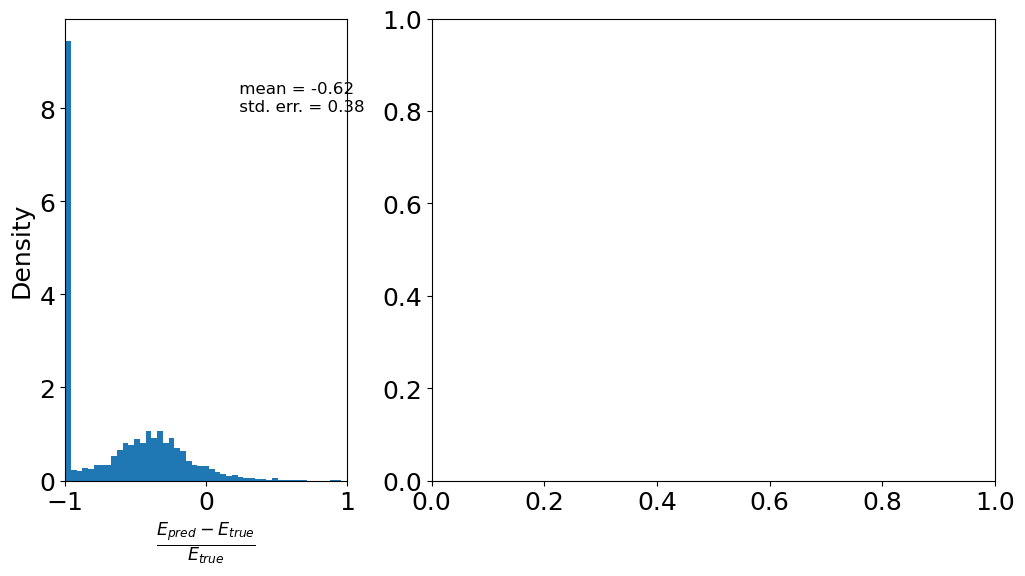

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1., 2]})

ax = axes[0]
frac_energy_diff = energy_diffs/energy_sums
ax.hist(frac_energy_diff, bins=np.linspace(-1, 1, 50), density=True)
ax.set_xlabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$')
ax.set_ylabel('Density')
ax.text(0.6, 0.8, f' mean = {frac_energy_diff.mean():.2f} \n std. err. = {frac_energy_diff.std():.2f}', fontsize=12, transform=ax.transAxes)

ax.set_xlim(-1, 1)

ax = axes[1]

ebin = np.array([0, 10, 20, 30, 50, 80, 140, 250, 500, 1000])
eratio_means = []
eratio_stds = []
for elow, ehigh in zip(ebin[:-1], ebin[1:]):
    mask = (energy_sums > elow) & (energy_sums < ehigh)
    esum = energy_sums[mask]
    esum_pred = energy_sums_pred[mask]
    
    eratio = esum/esum_pred
    eratio_means.append(eratio.mean())
    eratio_stds.append(eratio.std())
    
ax.errorbar(ebin, eratio_means, eratio_stds) 
ax.set_ylabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$', size=16)
ax.set_xlabel(r'$E_{true}$')
ax.set_xlim(0.1, 1e3)

plt.tight_layout()
plt.savefig(f'plots/ae_energy_resolution_{scenario}.png')
plt.show()